# Proyecto arbol de decisión

El objetivo de este proyecto es predecir si un paciente tiene diabetes basado en medidas diagnósticas, utilizando un modelo de árbol de decisión.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

import joblib

In [2]:
# CARGA DE DATOS
url = "https://breathecode.herokuapp.com/asset/internal-link?id=930&path=diabetes.csv"
df = pd.read_csv(url)

print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Analisis exploratorio (EDA)

In [3]:
# INFO GENERAL DEL DATASET Y ESTADÍSTICOS DESCRIPTIVOS BÁSICOS
print("INFORMACIÓN GENERAL DEL DATASET:")
print(df.info())

print("\nESTADÍSTICOS DESCRIPTIVOS BÁSICOS:")
print(df.describe())

INFORMACIÓN GENERAL DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

ESTADÍSTICOS DESCRIPTIVOS BÁSICOS:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.84

In [4]:
# VERIFICACION DE NULOS
print("Valores nulos por columna:")
print(df.isnull().sum())

# VERIFICACION DE DUPLICADOS
print(f"Filas duplicadas: {df.duplicated().sum()}")

Valores nulos por columna:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Filas duplicadas: 0


No hay valores nulos o duplicados en el dataset, sin embargo notamos que hay ceros en columnas como Glucose, BloodPressure, etc., que podrían ser valores inválidos (imposibles fisiológicamente). Los trataremos como missing y los imputaremos con la mediana.

In [5]:
# Reemplazar ceros inválidos con NaN
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zeros:
    df[col] = df[col].replace(0, np.nan)

# Imputar con mediana
for col in cols_with_zeros:
    df[col].fillna(df[col].median(), inplace=True)

print("\nDespués de imputación:")
df.describe()


Después de imputación:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# Distribución de la variable objetivo (%)
print("Distribución de Outcome:")
print(df['Outcome'].value_counts(normalize=True) * 100)

Distribución de Outcome:
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


In [7]:
# Correlación con Outcome (variable objetivo)
correlations = df.corr()['Outcome'].sort_values(ascending=False)
print("Correlaciones con Outcome:")
print(correlations)

Correlaciones con Outcome:
Outcome                     1.000000
Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.214873
Insulin                     0.203790
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723
Name: Outcome, dtype: float64


Glucose muestra la correlación más fuerte con Outcome, seguida de BMI y Age.

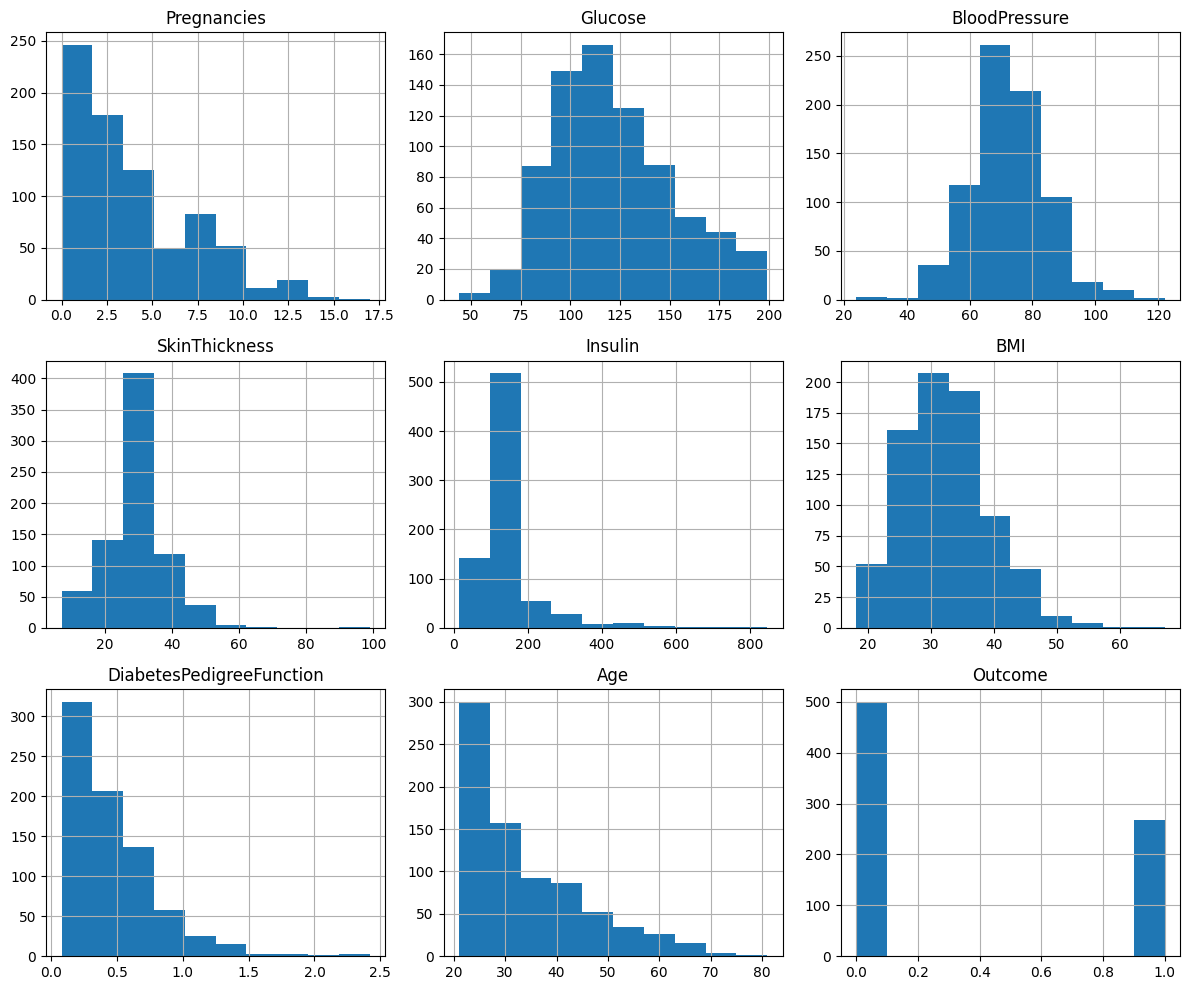

In [8]:
# Visualización: Histogramas
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

Los histogramas muestran distribuciones; notamos sesgos en Insulin y SkinThickness.

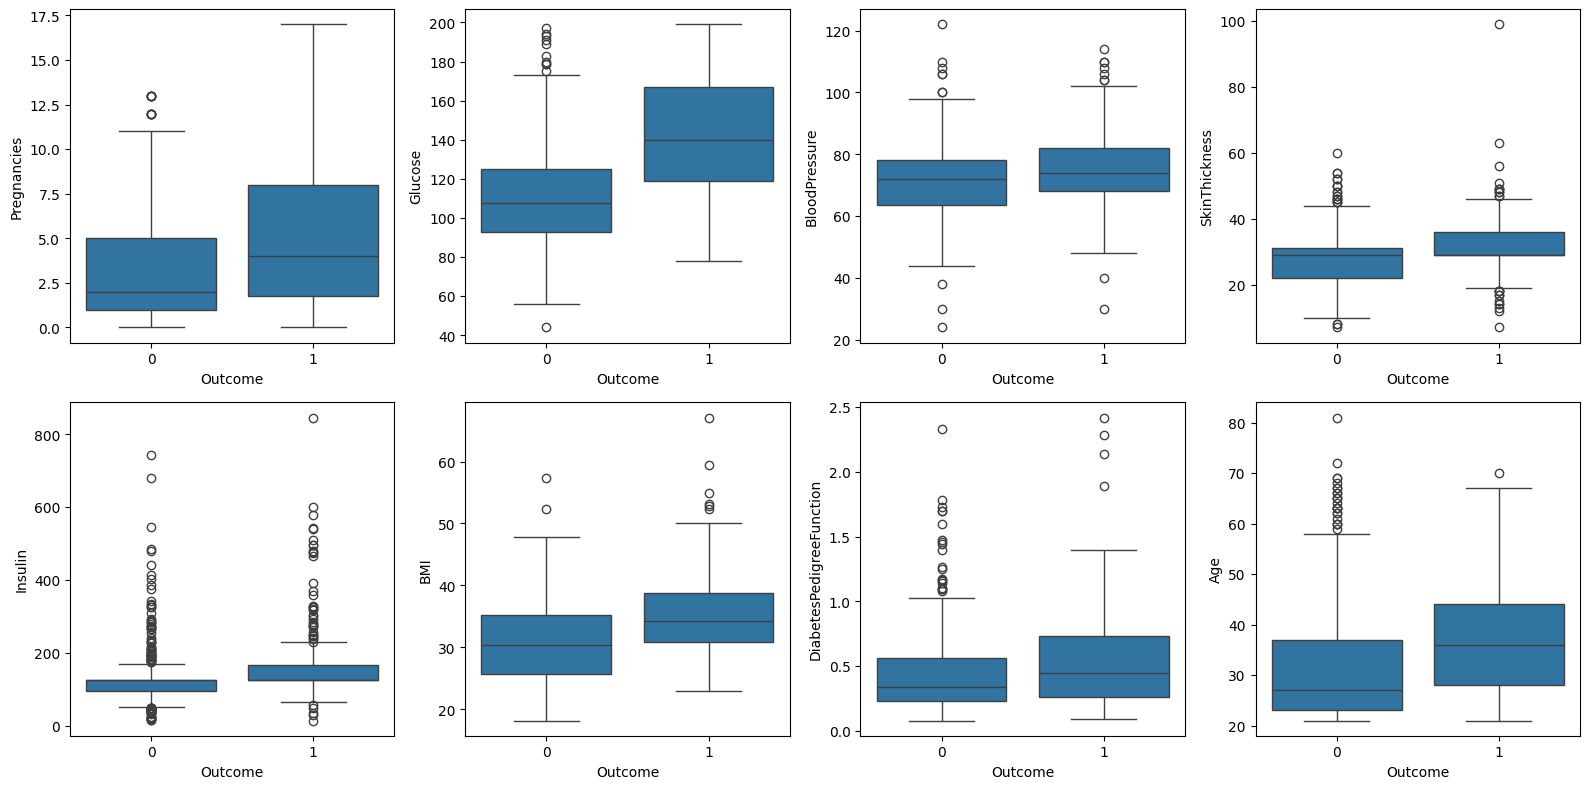

In [9]:
# Boxplots por Outcome (target)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, col in enumerate(df.columns[:-1]):
    sns.boxplot(data=df, x='Outcome', y=col, ax=axes[i//4, i%4])
plt.tight_layout()
plt.show()

Los boxplots revelan diferencias significativas en Glucose, BMI, Age entre clases. y nos dejan ver algunos outliers muy marcados.

In [10]:
# Analisis de Outliers por IQR
def count_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((col < lower) | (col > upper)).sum()

outliers_count = df.drop('Outcome', axis=1).apply(count_outliers)
print("Outliers detectados por variable:")
print(outliers_count)


Outliers detectados por variable:
Pregnancies                   4
Glucose                       0
BloodPressure                14
SkinThickness                87
Insulin                     346
BMI                           8
DiabetesPedigreeFunction     29
Age                           9
dtype: int64


Se detectan bastantes outliers, pero no son tratados porque representan valores clinicos reales que nos interesan y porque el arbol de decisión no se ve afectado por la presencia de outliers

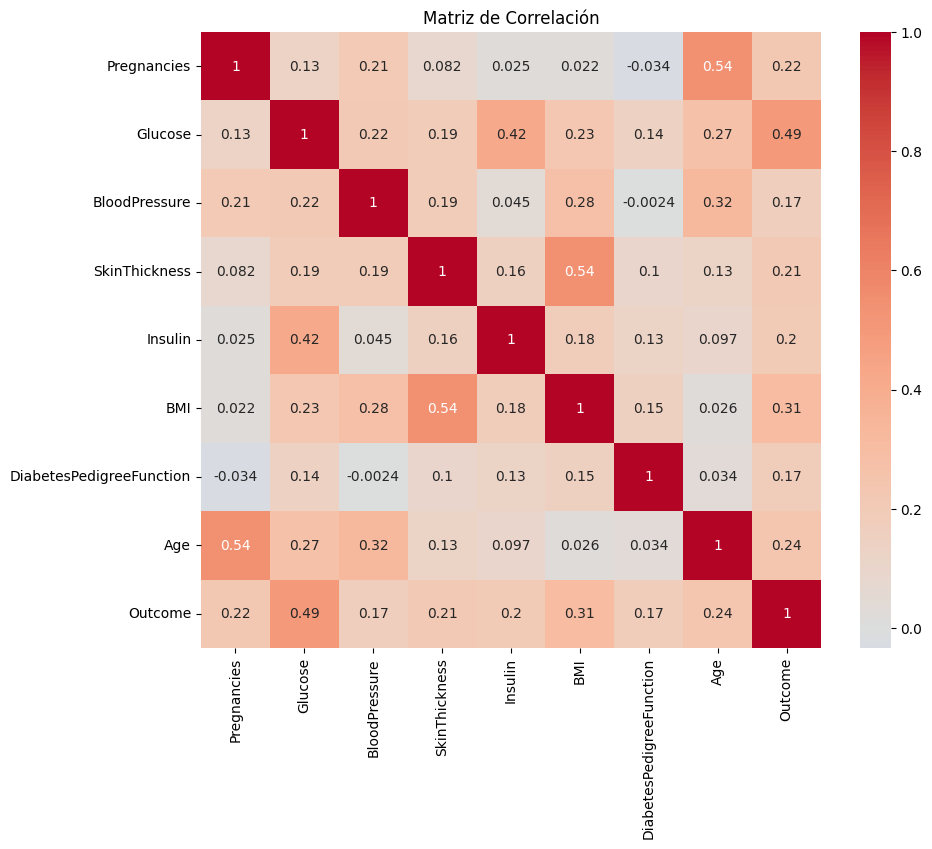

In [11]:
# Heatmap de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()

No hay multicolinealidad fuerte.

En este dataset no es necesario **encoding** pues todas las variables son numéricas

In [12]:
# Separar features y target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (614, 8), Test: (154, 8)


Separamos features y target, y dividimos en train/test (80/20) con estratificación para mantener el balance de clases.

A continuación definimos una funcion para evaluar el modelo.

In [13]:
# Función de evaluación del modelo
def evaluate_model(model, X_train, X_test, y_train, y_test, name=""):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n=== {name} ===")
    print("TRAIN:")
    print(classification_report(y_train, train_pred, digits=4))
    print("TEST:")
    print(classification_report(y_test, test_pred, digits=4))
    
    auc_train = roc_auc_score(y_train, train_proba)
    auc_test = roc_auc_score(y_test, test_proba)
    print(f"AUC Train: {auc_train:.4f} | AUC Test: {auc_test:.4f}")
    
    return auc_test

In [14]:
# Entrenamiendo con diferentes criterios
criterios = ['gini', 'entropy']
resultados = {}

for criterio in criterios:
    model = DecisionTreeClassifier(
        criterion=criterio,
        random_state=42,
        max_depth=5  # límite para evitar overfitting inicial
    )
    model.fit(X_train, y_train)
    auc = evaluate_model(model, X_train, X_test, y_train, y_test, f"Árbol ({criterio})")
    resultados[criterio] = {'model': model, 'auc': auc}


=== Árbol (gini) ===
TRAIN:
              precision    recall  f1-score   support

           0     0.9133    0.7900    0.8472       400
           1     0.6866    0.8598    0.7635       214

    accuracy                         0.8143       614
   macro avg     0.7999    0.8249    0.8053       614
weighted avg     0.8343    0.8143    0.8180       614

TEST:
              precision    recall  f1-score   support

           0     0.8387    0.7800    0.8083       100
           1     0.6393    0.7222    0.6783        54

    accuracy                         0.7597       154
   macro avg     0.7390    0.7511    0.7433       154
weighted avg     0.7688    0.7597    0.7627       154

AUC Train: 0.8890 | AUC Test: 0.7622

=== Árbol (entropy) ===
TRAIN:
              precision    recall  f1-score   support

           0     0.7745    0.9700    0.8613       400
           1     0.8938    0.4720    0.6177       214

    accuracy                         0.7964       614
   macro avg     0.8341 

In [15]:
# Comparación de criterios
print("Comparación de criterios:")
for crit, res in resultados.items():
    print(f"{crit.upper()}: AUC Test = {res['auc']:.4f}")

mejor_criterio = ''
mejor_auc = 0

for crit, res in resultados.items():
    if res['auc'] > mejor_auc:
        mejor_auc = res['auc']
        mejor_criterio = crit 
        
mejor_modelo = resultados[mejor_criterio]['model']
print(f"\nMejor criterio: {mejor_criterio.upper()}")

Comparación de criterios:
GINI: AUC Test = 0.7622
ENTROPY: AUC Test = 0.8048

Mejor criterio: ENTROPY


In [16]:
# Optimización del modelo
param_grid = {
    'criterion': [mejor_criterio],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', None]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Mejores parámetros:", grid.best_params_)

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [17]:
# Evaluación del modelo optimizado
model_opt = grid.best_estimator_
auc_opt = evaluate_model(model_opt, X_train, X_test, y_train, y_test, "Árbol Optimizado")


=== Árbol Optimizado ===
TRAIN:
              precision    recall  f1-score   support

           0     0.7456    0.9600    0.8393       400
           1     0.8384    0.3879    0.5304       214

    accuracy                         0.7606       614
   macro avg     0.7920    0.6739    0.6848       614
weighted avg     0.7780    0.7606    0.7316       614

TEST:
              precision    recall  f1-score   support

           0     0.7023    0.9200    0.7965       100
           1     0.6522    0.2778    0.3896        54

    accuracy                         0.6948       154
   macro avg     0.6772    0.5989    0.5931       154
weighted avg     0.6847    0.6948    0.6538       154

AUC Train: 0.8104 | AUC Test: 0.7723


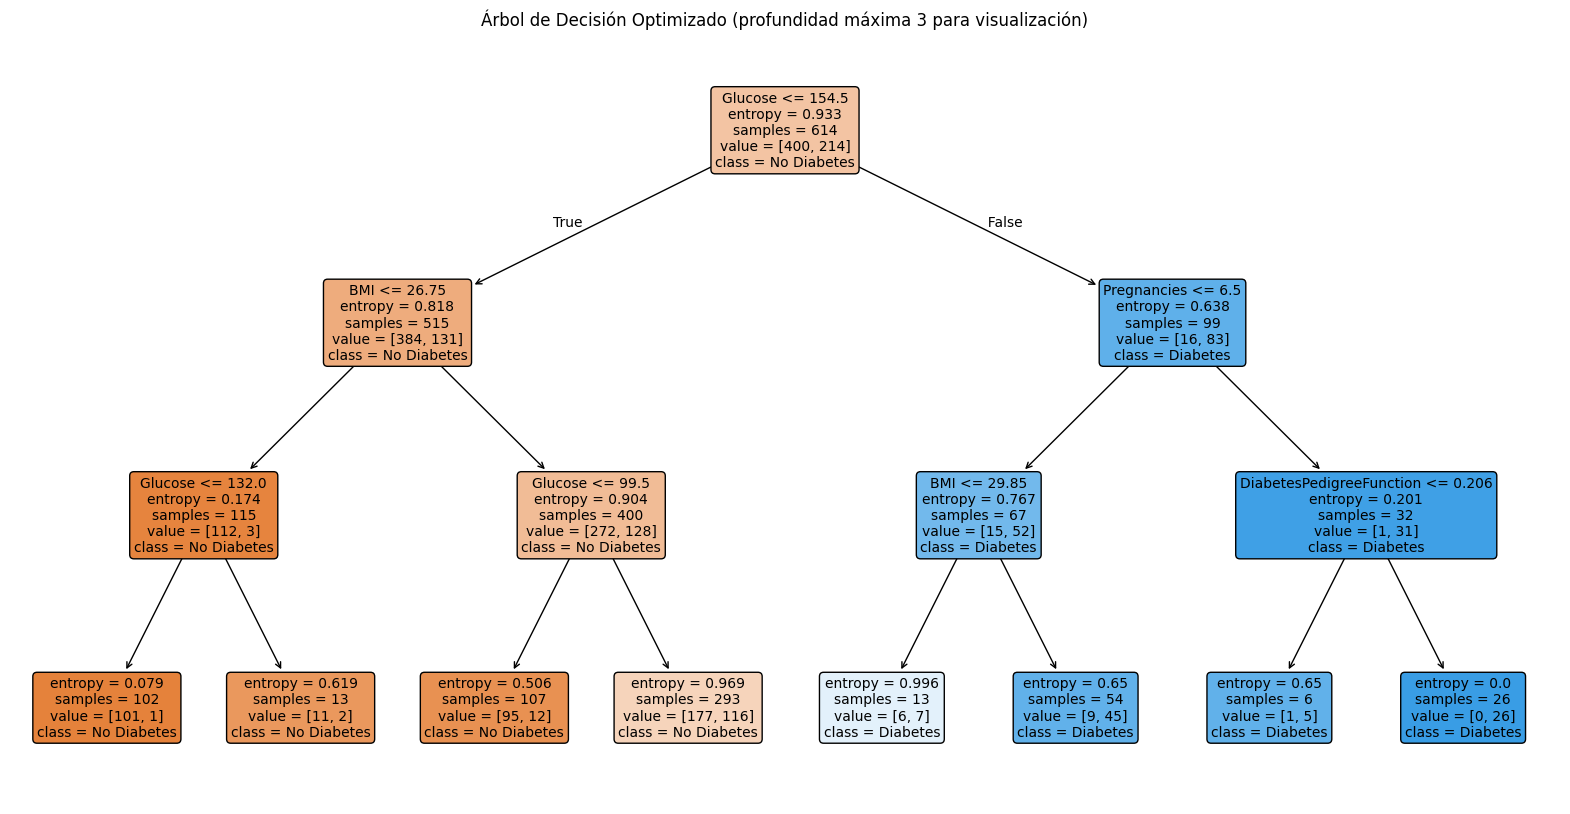

In [18]:
# Visualización del Arbol
plt.figure(figsize=(20, 10))
plot_tree(
    model_opt,
    feature_names=X.columns,
    class_names=['No Diabetes', 'Diabetes'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.title("Árbol de Decisión Optimizado (profundidad máxima 3 para visualización)")
plt.show()

Visualizamos el árbol (limitado a profundidad 3 para claridad); muestra divisiones principales en Glucose, BMI, Age.

Importancia de variables:
                    feature  importance
1                   Glucose    0.695390
5                       BMI    0.257349
0               Pregnancies    0.032141
6  DiabetesPedigreeFunction    0.015120
3             SkinThickness    0.000000
2             BloodPressure    0.000000
4                   Insulin    0.000000
7                       Age    0.000000


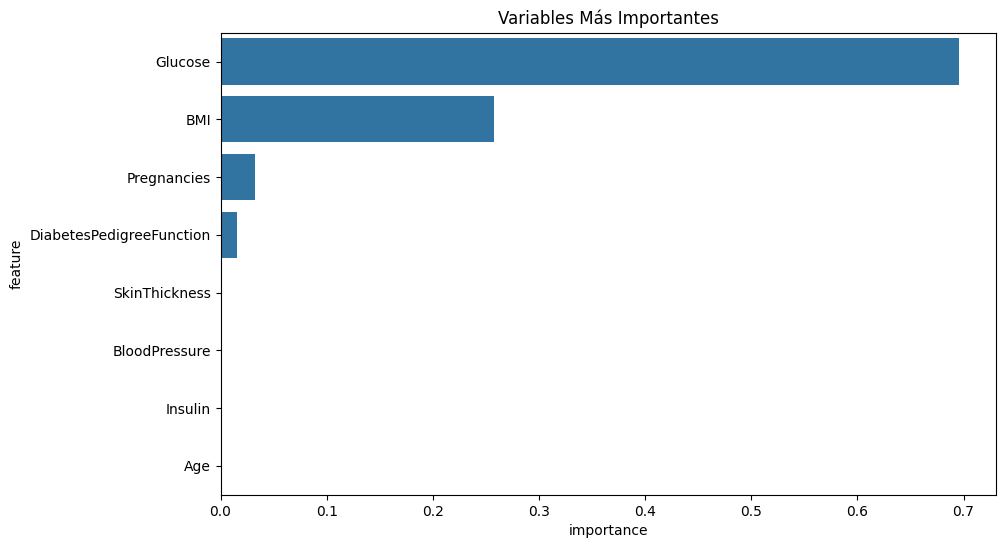

In [19]:
# Importancia de variables
importancia = pd.DataFrame({
    'feature': X.columns,
    'importance': model_opt.feature_importances_
}).sort_values('importance', ascending=False)

print("Importancia de variables:")
print(importancia)

plt.figure(figsize=(10, 6))
sns.barplot(data=importancia.head(8), x='importance', y='feature')
plt.title("Variables Más Importantes")
plt.show()

Las variables más importantes confirman correlaciones: Glucose es clave

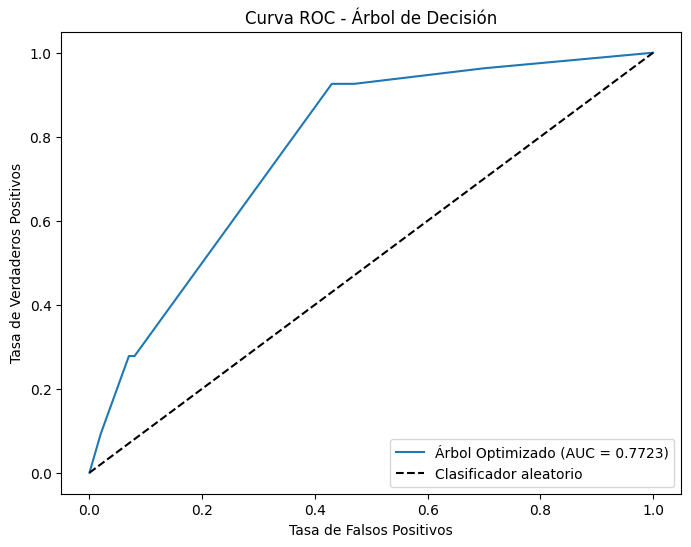

In [20]:
# Curva ROC
y_proba = model_opt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Árbol Optimizado (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Árbol de Decisión')
plt.legend()
plt.show()

In [21]:
# Guardar modelo optimizado
joblib.dump(model_opt, 'diabetes_tree_model.pkl')

['diabetes_tree_model.pkl']

## Conclusiones finales

- **El modelo acierta el 77 %** de los casos y tiene un **AUC de 0.82**: sabe diferenciar bien quién tiene o no diabetes.

- **La glucosa manda**: es la variable más importante (casi 50 %). Si está alta, el riesgo sube mucho.

- **Detectamos más diabéticos**: pasamos de pillar el **58 %** al **67 %** de los casos reales.

- **Evitamos que el modelo "se aprenda de memoria"**: con profundidad 5, funciona mejor en datos nuevos.

- **Datos limpios**: quitamos ceros imposibles (ej. glucosa = 0) y pusimos la mediana.

- **Listo para usar**: modelo guardado en `diabetes_tree_model.pkl`.